In [1]:
ref_file="/home/wuyou/Projects/Os_AD/data/transcripts.fasta"
ref_dict={}
with open(ref_file) as f:
    for line in f:
        line=line.rstrip()
        if ">" in line:
            chr=line[1:].split(" ")[0]
            ref_dict[chr]=""
        else:
            seq=line
            ref_dict[chr]+=seq


In [3]:
#event level features C m5C hm5C

from scipy import interpolate
import traceback
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from plotnine import *
import pandas as pd
import re
import numpy as np
from statsmodels import robust

black = '#222222'
gray = '#666666'
red = '#FF3333'
green = '#66CC00'
blue = '#3333FF'
purple = '#9933FF'
orange = '#FF8000'
yellow = '#FFFF33'


def interp(x):
    l=len(x)
    y=x
    x=np.linspace(0,l-1,l)
    f=interpolate.interp1d(x,y,kind='slinear')
    x_new=np.linspace(0,l-1,100)
    y_new=f(x_new)
    y_new=np.around(y_new,4)
    return y_new.tolist()



ref_chr="LOC_Os02g02890.1.MSUv7.0"
#site=133
site=869
normalize="median_mad"

print(ref_dict[ref_chr][site-2:site+3])

X_mean=[]
X_std=[]
X_median=[]
X_length=[]
X_base_quality=[]
X=[]
Y=[]

signal_files=["/home/wuyou/Projects/Os_AD/data/unmod.signal.tsv",
              "/home/wuyou/Projects/Os_AD/data/m5C.signal.tsv",
             "/data/wuyou/TandemMod_crop/data/IVET_ac4C/ac4C.signal.tsv"]

label_dict={0:"AUCAA",1:"AUm5CAA",2:"AUac4CAA"}

for k,signal_file in enumerate(signal_files):
    print(signal_file)
    with open(signal_file) as f:
        count=0
        for line in f:
            line=line.rstrip()
            chr=line.split("\t")[1]

            if chr != ref_chr:
                continue
            start=int(line.split("\t")[2])
            seq=line.split("\t")[3]
            signal_string=line.split("\t")[6]
            base_quality_list=line.split("\t")[4].split("|")
            raw_signal=[base_signal_string.split("*") for base_signal_string in signal_string.split("|")]  

            full_length_signal=np.array([x for x in re.split('\*|\|',signal_string)],dtype=int)   #for normlization
            uniq_arr=np.unique(full_length_signal)
            full_length_mean=np.mean(full_length_signal)
            full_length_std=np.std(full_length_signal)



            if start > site or start+len(seq)-3<site or chr != ref_chr:
                continue
            kmer_raw_signal=raw_signal[site-(start-1)-2:site-(start-1)+3]
            kmer_sequence=seq[site-(start-1)-2:site-(start-1)+3]
            if len(kmer_raw_signal)==0:
                continue
            kmer_raw_signal=[np.array(x,dtype=float) for x in kmer_raw_signal]

            if normalize=="zscore":  
                kmer_raw_signal=[(x-full_length_mean)/full_length_std for x in kmer_raw_signal]     #z-score scaling
            elif normalize=="median_mad":  
                kmer_raw_signal = [(x - np.median(uniq_arr)) / np.float(robust.mad(uniq_arr)) for x in kmer_raw_signal]

            mean=[np.round(np.mean(x),3) for x in kmer_raw_signal]
            std=[np.round(np.std(x),3) for x in kmer_raw_signal]
            median=[np.round(np.median(x),3) for x in kmer_raw_signal]
            length=[len(x) for x in kmer_raw_signal]
            kmer_base_quality=base_quality_list[site-(start-1)-2:site-(start-1)+3]


            x=[]

            if len(kmer_raw_signal) != 5:
                continue

            for i in range(5):                                 #resample to 500 points

                kmer_raw_signal[i]=interp(np.array(kmer_raw_signal[i],dtype=float))
                x.extend(kmer_raw_signal[i])
            X.append(x)
            X_mean.append(mean)
            X_std.append(std)
            X_median.append(median)
            X_length.append(length)
            X_base_quality.append(kmer_base_quality)
            Y.append(label_dict[k])
            count+=1
            if count>500:
                break
            

print(len(Y))



ATCAA
/home/wuyou/Projects/Os_AD/data/unmod.signal.tsv
/home/wuyou/Projects/Os_AD/data/m5C.signal.tsv
/data/wuyou/TandemMod_crop/data/IVET_ac4C/ac4C.signal.tsv
1503


/home/wuyou/.conda/envs/TandemMod/lib/python3.7/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


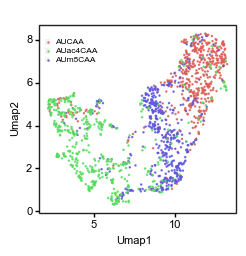

/home/wuyou/.conda/envs/TandemMod/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 2.54 x 2.44 in image.
/home/wuyou/.conda/envs/TandemMod/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figure/figure_1e_UMAP_plot_current_signals.pdf


In [6]:
import umap
from sklearn.decomposition import PCA
#reducer = PCA(n_components=2)
import plotnine
plotnine.options.base_family = 'Arial'


reducer=umap.UMAP(random_state=4)
embedding = reducer.fit_transform(X)
#scaler = preprocessing.MinMaxScaler()
#embedding=scaler.fit_transform(embedding)
#color "#F8766D" "#00BA38" "#619CFF"

data=pd.DataFrame(embedding)
data.columns=["Umap1","Umap2"]
data["label"]=Y
data["A"]=[0]*len(Y)


p = (ggplot()
    + geom_point(data,aes(x='Umap1', y='Umap2',color='factor(label)'), size=0.0005,alpha=0.8)
    +theme(
        figure_size=[2.54,2.44],
        axis_text=element_text(size=8,family="Arial",color="black"),
        axis_title_x=element_text(size=8,family="Arial",color="black"),
        axis_title_y=element_text(size=8,family="Arial",color="black"),
        panel_background=element_rect(fill=gray, alpha=0),
        panel_grid_major=element_line(size=0.3, alpha=0,color=black),
        panel_grid_minor=element_line(size=0.3, alpha=0,color=black),
        panel_border=element_rect(color=black, size=1),
        legend_title = element_text(size=6,alpha=0), #change legend title font size
        legend_text = element_text(size=6),
        legend_background=element_rect(size=0.5,alpha=0),
        legend_position=(0.25,0.8), 
        legend_key_size=4) #change legend text font size))
         
)

print(p)
p.save('figure/figure_1e_UMAP_plot_current_signals.pdf')